# DTSA 5509 - Final Project
### Author: Chris Murphy

# Predicting English Premier League Outcomes 

## Project Topic

For my supervised learning project, I have decided to attempt to accurately predict the outcome of English Premier League football (soccer) games. In football, each team plays 38 games in a season with each team playing one another both at their home stadium and at their opponents stadium. The outcome of each game could be a win, draw, or loss which results in earning three, one, or zero points respectively. The team with the most points after the 38 game season wins the league.

My goal of this project is to most accurately predict any one game's outcomes in a season. I am personally a big fan of the English Premier League and will find modeling Premier League data very interesting. Although the results of the models I will complete will not lead to any 'ground breaking' research, the project as a whole will still serve as a terrific experience for myself to practice applying supervised machine learning models to different types of data. Upon completion of this project, I hope to have gained a better understanding of the entire end to end data science project process as well as to master using the three supervised learning models.

Since I will be attempting to predict the outcome of the game (either a W, D, or L) my task is a classification problem. I will attempt to apply three supervised learning models: multiple linear regression, decision tree classifier, and Adaboost classification models.

## Data

I have located a dataset from Kaggle with scraped premier league result data from the 2017-2022 seasons. The citation to the Kaggle dataset can be found in the ‘Citations’ section below. The source of this data is from a popular football statistics page called fbref. The citation to the fbref Premier League Stats homepage in the ‘Citations’ section below.

The dataset includes the result for each game played throughout the 2017-2022 seasons, as well as other match statistics. Since the data spans from 2017-2022, the data was scraped once for each team and season. Therefore, a total of 95 pages were scraped and aggregated into one dataset. A full breakdown of the dataset columns can be found below. The dataset contains 4092 rows and 24 columns. Each row reflects the date when the match was played, which teams were playing, statistics around the match, and finally the outcome which I will be predicting on. Of the 24 columns in the dataset, there is one datetime column, 12 float columns, 1 int column, and 11 object columns.


### Main stats

Date - the date the match was played

Time - time of day when the match was played

Round - of the 38 games played, which matchweek did this game take place?

Day - day of week when the match was played

Venue - whether the match is home or away for the 'Team'

Result - the outcome of the game (W, D, L)

xG - expected goals

xGA - expected allowed goals

Poss - possession of the ball

GF - goals scored

GA - goals allowed

Opponent - who was the 'Team' playing against?

Attendance - the number of supporters in the stadium

Captain - who the captain of the 'Team' was for that match

Formation - the formation the players of the 'Team' took to start the game

Referee - who was the referee for the particular game?

Season - which year the game took place

Team - the team involved in the match

### Shooting stats

Sh - total number of shots

SoT - shots on target

Dist - average distance in yards from goal of all shots taken

FK - shots from free kicks

PK - penalty kicks made

PKatt - penalty kicks attempted


## Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn specific imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.model_selection import RepeatedStratifiedKFold

# statsmodels imports
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data import and cleaning

Although it was relatively easy to import the Kaggle dataset using the raw Github file, there were a few data cleaning considerations I had to make before I could continue. To start, I noticed there were three columns that contained only null values. Those columns were ‘Notes’, ‘Match Report’ and ‘Comp’. Since these columns were null, I decided they should be dropped.

The next transformation I made was to transform the ‘Date’ column to a pandas datetime. This is considered good practice if there are any date specific transformations or visualizations that will use this column. There were no other columns that needed their data type transformed.

The third transformation I made was to impute values for both the ‘Attendance’ and ‘Dist’ columns. Considering the models I will be using, the multiple linear regression model will not accept any null values, meaning I will have to have an acceptable value for each column for each row. Of the 4092 rows, there were 880 instances where the ‘Attendance’ column was null and 3 instances where the ‘Dist’ column was null. In both cases, I decided to impute values for the null values using the colum mean value. This was decided upon by looking at the min, max, and standard deviation values of the column and deciding that the mean was not skewed and therefore would be a suitable choice.

The final transformation I made was the most complex. Because many of my columns were categorical values (for example ‘Referee’, ‘Team’, ‘Opponent’ etc.), I would need to encode these columns to numbers for the models (especially the multiple linear regression model) to calculate their relationship. To do this, I used the LabelEncoder method in the sklearn library. Each column where the datatype was ‘object’ was converted into a number. I created a copy of my original dataset that will serve as the set I will train and test my models against. 

In [2]:
# declaring the URL of the raw csv dataframe from Kaggle that I will be using
url = 'https://github.com/cmannnn/predicting_premier_league_games/blob/main/datasets/main17-23.csv?raw=true'

# reading in the data with pandas read_csv
df = pd.read_csv(url)

# viewing the first 5 rows of the data
# there might be a few issues to address
df.head()

Date   Time            Comp        Round  Day Venue Result   GF   GA  \
0  2022-08-05  20:00  Premier League  Matchweek 1  Fri  Away      W  2.0  0.0   
1  2022-08-13  15:00  Premier League  Matchweek 2  Sat  Home      W  4.0  2.0   
2  2022-08-20  17:30  Premier League  Matchweek 3  Sat  Away      W  3.0  0.0   
3  2022-08-27  17:30  Premier League  Matchweek 4  Sat  Home      W  2.0  1.0   
4  2022-08-31  19:30  Premier League  Matchweek 5  Wed  Home      W  2.0  1.0   

         Opponent  ...  Match Report  Notes    Sh  SoT  Dist   FK   PK PKatt  \
0  Crystal Palace  ...  Match Report    NaN  10.0  2.0  14.6  1.0  0.0   0.0   
1  Leicester City  ...  Match Report    NaN  19.0  7.0  13.0  0.0  0.0   0.0   
2     Bournemouth  ...  Match Report    NaN  14.0  6.0  14.8  0.0  0.0   0.0   
3          Fulham  ...  Match Report    NaN  22.0  8.0  15.5  1.0  0.0   0.0   
4     Aston Villa  ...  Match Report    NaN  22.0  8.0  16.3  1.0  0.0   0.0   

   Season     Team  
0    2022  Arsenal  
1    2022  Arsenal  
2    2022  Arsenal  
3    2022  Arsenal  
4    2022  Arsenal  

[5 rows x 27 columns]

In [3]:
# in the output above, there seems to be a lot of null values in the 'Notes' column
# the code below reveals all 4092 'Notes' values are null
# this column will be dropped 
print(f'The number of null values in the \'Notes\' column is : {df['Notes'].isnull().sum()}')

The number of null values in the 'Notes' column is : 4092


In [4]:
# another issue, for both the 'Match Report' and 'Comp' columns there is only one value for each column
# these columns will not be helpful in our results
# both these columns will be dropped as well
df[['Match Report', 'Comp']].value_counts()

Match Report  Comp          
Match Report  Premier League    4092
Name: count, dtype: int64

In [5]:
# dropping the 'Notes', 'Match Report' and 'Comp' columns from the dataframe df
df.drop(columns=['Notes', 'Match Report', 'Comp'], inplace = True)

In [6]:
# by looking at the .info() method, the 'Date' columns' data type is an object
# this should be changed so pandas can treat it as a datetime in our analysis
df['Date'].info()

# changing the 'Date' column to a datetime value
df['Date'] = pd.to_datetime(df['Date'])

<class 'pandas.core.series.Series'>
RangeIndex: 4092 entries, 0 to 4091
Series name: Date
Non-Null Count  Dtype 
--------------  ----- 
4092 non-null   object
dtypes: object(1)
memory usage: 32.1+ KB


In [7]:
# there are a few null values in both the 'Attendance' and the 'Dist' columns
# lets see how these null values can be best imputed
print(f'Attendence col null values: {df['Attendance'].isnull().sum()}')
print(f'Dist col null values: {df['Dist'].isnull().sum()}')

Attendence col null values: 880
Dist col null values: 3


In [8]:
# here we see in the 'Attendance' column, the mean does a good job of capturing the 'middle' of the data
# same story with the 'Dist' column
# therefore the mean will be used to impute the null values for both of those columns
df[['Attendance','Dist']].describe()

Attendance         Dist
count   3212.000000  4089.000000
mean   38233.239103    17.675373
std    17034.715436     3.039178
min     2000.000000     5.300000
25%    25286.000000    15.700000
50%    32092.500000    17.600000
75%    53206.000000    19.500000
max    83222.000000    35.000000

In [9]:
df['Attendance'] = df['Attendance'].fillna(df['Attendance'].mean())
df['Dist'] = df['Dist'].fillna(df['Dist'].mean())

In [10]:
# here is a look at the second row in the df dataframe, it's looking good!
df.iloc[1]

Date          2022-08-13 00:00:00
Time                        15:00
Round                 Matchweek 2
Day                           Sat
Venue                        Home
Result                          W
GF                            4.0
GA                            2.0
Opponent           Leicester City
xG                            2.7
xGA                           0.5
Poss                         50.0
Attendance                60033.0
Captain           Martin Ødegaard
Formation                   4-3-3
Referee            Darren England
Sh                           19.0
SoT                           7.0
Dist                         13.0
FK                            0.0
PK                            0.0
PKatt                         0.0
Season                       2022
Team                      Arsenal
Name: 1, dtype: object

In [11]:
# now that the df dataframe is cleaned, lets create a copy before we encode the columns where the data type = 'object'
dfc = df.copy()

In [12]:
# in this cell, for each column where the data type is 'object', I'm changing the values to integers that the models will be able to use later on
# the printed values is how the values are encoded
# ex: 0 will equal a draw in the result column, a 1 will equal a loss in the result column etc.
le = LabelEncoder()
object_columns = dfc.select_dtypes(include = 'object').columns
for col in object_columns:
    ev = pd.Series(le.fit_transform(dfc[col]))
    new_cols = [col + '_encoded_' + str(val) for val in le.classes_]

    # can turn this on and off to get label encded col names
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)

    encoded_df = pd.DataFrame(ev, columns=[col + '_encoded'])

    dfc = pd.concat([dfc, encoded_df], axis = 1)
    dfc.drop(columns = [col], inplace = True)

{'12:00': 0, '12:30': 1, '13:30': 2, '14:00': 3, '14:05': 4, '14:15': 5, '15:00': 6, '16:00': 7, '16:15': 8, '16:30': 9, '17:15': 10, '17:30': 11, '17:45': 12, '18:00': 13, '19:00': 14, '19:15': 15, '19:30': 16, '19:45': 17, '20:00': 18, '20:15': 19, '20:30': 20}
{'Matchweek 1': 0, 'Matchweek 10': 1, 'Matchweek 11': 2, 'Matchweek 12': 3, 'Matchweek 13': 4, 'Matchweek 14': 5, 'Matchweek 15': 6, 'Matchweek 16': 7, 'Matchweek 17': 8, 'Matchweek 18': 9, 'Matchweek 19': 10, 'Matchweek 2': 11, 'Matchweek 20': 12, 'Matchweek 21': 13, 'Matchweek 22': 14, 'Matchweek 23': 15, 'Matchweek 24': 16, 'Matchweek 25': 17, 'Matchweek 26': 18, 'Matchweek 27': 19, 'Matchweek 28': 20, 'Matchweek 29': 21, 'Matchweek 3': 22, 'Matchweek 30': 23, 'Matchweek 31': 24, 'Matchweek 32': 25, 'Matchweek 33': 26, 'Matchweek 34': 27, 'Matchweek 35': 28, 'Matchweek 36': 29, 'Matchweek 37': 30, 'Matchweek 38': 31, 'Matchweek 4': 32, 'Matchweek 5': 33, 'Matchweek 6': 34, 'Matchweek 7': 35, 'Matchweek 8': 36, 'Matchweek 9'

In [13]:
# here is the same row we printed from our original df dataframe
# you can see all of the new encoded columns are suffixed with '_encoded' and now contains numbers instead of strings
# we are ready to move on to EDA!
dfc.loc[1]

Date                 2022-08-13 00:00:00
GF                                   4.0
GA                                   2.0
xG                                   2.7
xGA                                  0.5
Poss                                50.0
Attendance                       60033.0
Sh                                  19.0
SoT                                  7.0
Dist                                13.0
FK                                   0.0
PK                                   0.0
PKatt                                0.0
Season                              2022
Time_encoded                           6
Round_encoded                         11
Day_encoded                            2
Venue_encoded                          1
Result_encoded                         2
Opponent_encoded                      13
Captain_encoded                      121
Formation_encoded                     14
Referee_encoded                        5
Team_encoded                           0
Name: 1, dtype: 

## Visualizations

In this section, I will outline all the visualizations I put together using the dataset that was cleaned in the previous steps. I attempted to build graphs and visuals that were both eye catching, as well as being effective in getting information across. Overall, explatory data analysis (EDA) is a good step to include in any data science project. It allows the author and the reader of the project the ability to understand the data better which can lead to further analysis ideas. 

The first visual I like to create when working through a data science project such as this is to create a corelation plot. They do not require much code to stand up and produce a lot of very interesting data points . In the resulting chart, the 'Result_encoded' is what I'll be predicting on later in the notebook and wil be most important to look into. Columns that have a high relative positive correlation to our target column are 'GF', 'xG', 'SoT'. This is as expected. Goals for, expected goals, and shots on target are related to attacking proficiency which will no doubt have an impact on the result of the match.

Another interesting consideration of this graph is to identify which columns have a high relative negative correlation to our target column. Three columns that correlate most negatively to our result is 'GA' and 'xGA', and 'Dist'. This means that these columns also have an (negative) impact on the match outcome. Two of the values ('GA' and 'xGA'), make sense. Goals against and expected goals against is also as expected. These are bad metrics that will also have an impact on the result of the game. The interesting value to me was Distance. It seems that our initial correlation graph is indicating that teams whose players are stagnant on the field have worse results more often. This might be worth looking into further later on in the analysis.

<Axes: >

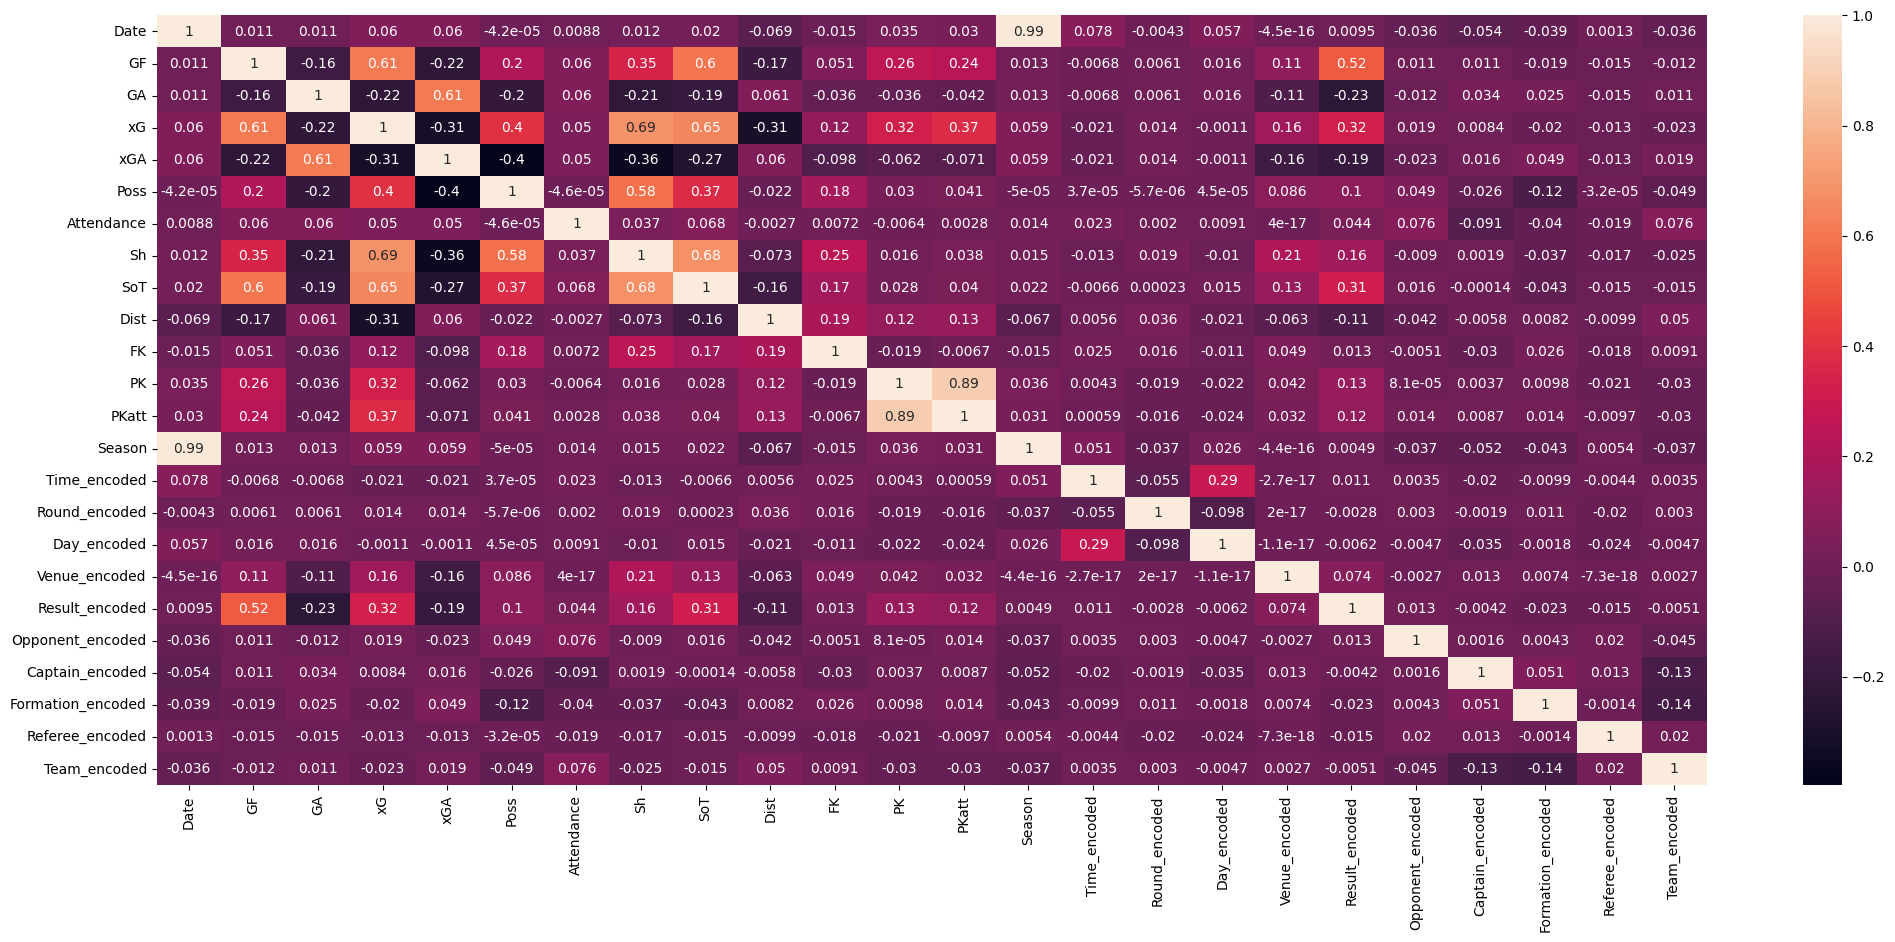

In [14]:
fig, ax = plt.subplots(figsize = (25, 10))
sns.heatmap(dfc.corr(), annot = True)

From the correlation chart, we now know that expected goals (xG) and expected goals against (xGA) have a big impact on the result of the game. This leads me to think about which teams have the highest and lowest average xG and xGA values across our dataset. The next graph will showcase which teams rank best and worse in these statistics. Below, the red bar reflects xGA and the blue bar reflects xG for each team. Manchester City and Liverpool blow every other team out of the water. This would be no suprise to any Premier League fan. Both Manchester City and Liverpool have been dominant over the 2017-2022 seasons and have had great success winning trophies and the league itself. Chelsea has the next best xG and xGA, but only slightly better than Arsenal and Manchester United.

On the flip side, Norwich City expects to concede almost 2 goals per game which is a terrible statistic. It doesn't help that they have the third lowest xG at 0.8. Rounding out the bottom three are Stoke City and Nottingham Forest, however there are a few other teams with comparabely bad xGA and xG ratios.

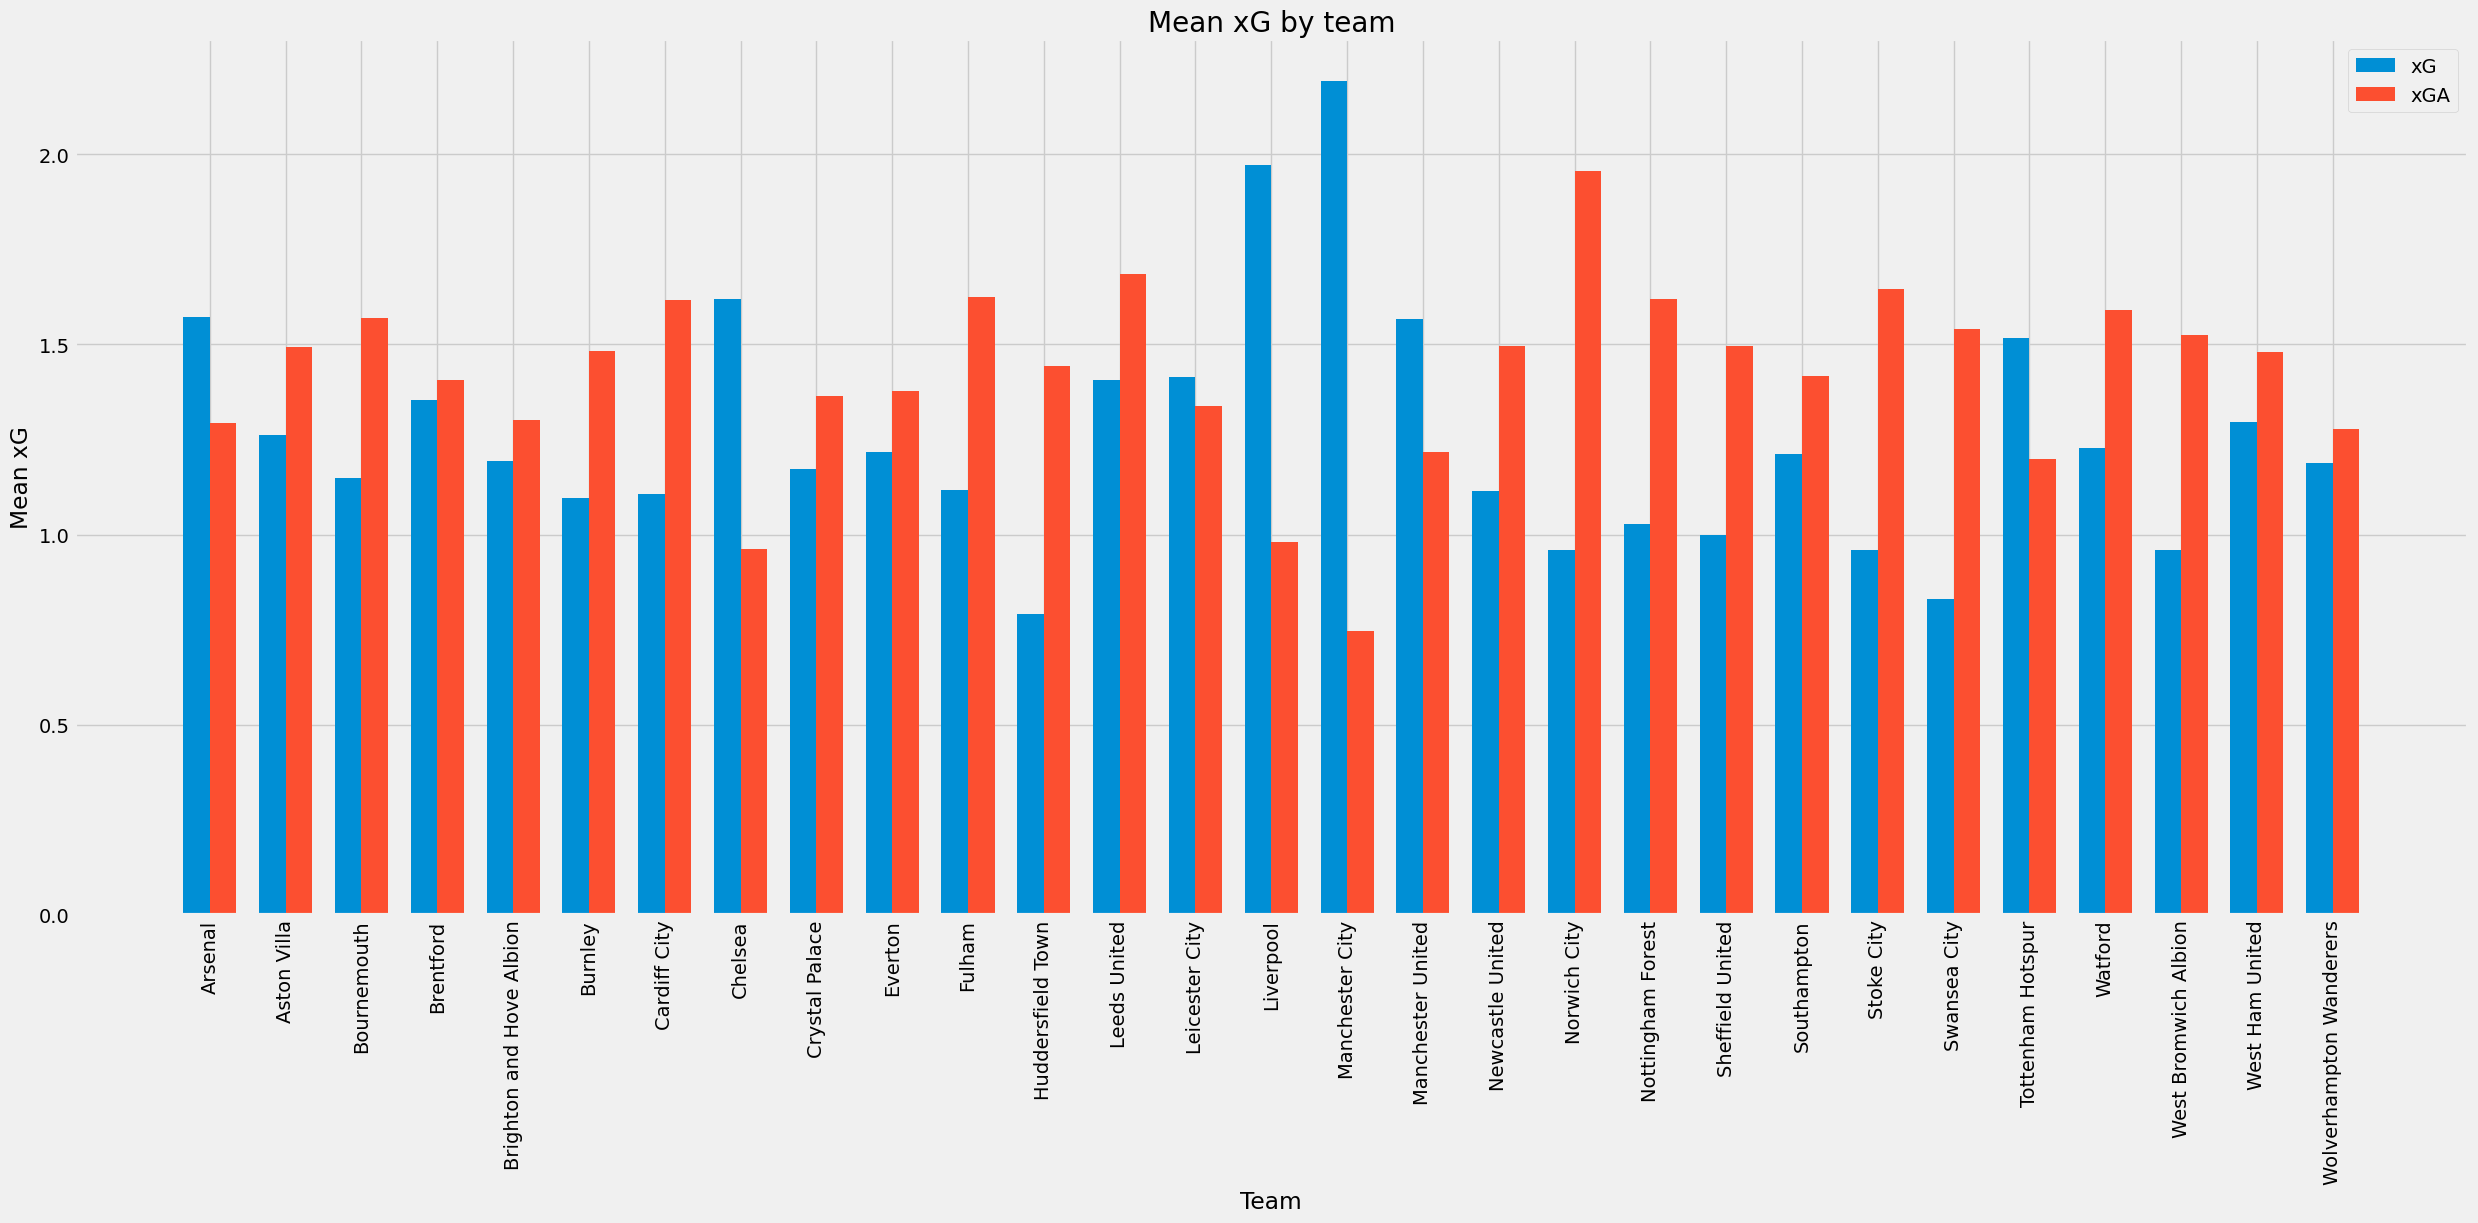

In [15]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

width = 0.35

xg = df['xG'].groupby(df['Team']).mean()
xga = df['xGA'].groupby(df['Team']).mean()

team_names = xg.index
ind = np.arange(len(team_names))

plt.bar(ind, xg, width, label = 'xG')
plt.bar(ind + width, xga, width, label = 'xGA')

plt.title('Mean xG by team')
plt.xlabel('Team')
plt.ylabel('Mean xG')
plt.tight_layout()
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(team_names, rotation = 90)

plt.legend(loc = 'best')
plt.show()

The next graph I created showcases a count of each result for each team across the 2017-2022 seasons. It should be noted that some teams have less overall results because they have just been promoted to the Premier League. For background, there are many tiers of football in England. At the end of each season, the three teams from each division with the lowest total points move down a division and the three teams from each division with the highest number of points moves up a division. Therefore, if a team has been promoted into the Premier League, there is no guarentee they will stay there year over year. They must earn more points than the third worst team to stay in the league.

Nottingham Forest represents this in the graph very well. They have the least amount of results out of any other team. From prior knowledge I know that Nottingham Forest played in the Premier League for only one season (2022-2023 season) where they won 9 games, tied 11, and lost 18 to finish 16/20th. Based on their results, they hung on and were not relagated this season.

It is no suprise again that Liverpool and Manchester City dominate the win columns. Manchester City won 157 games during the 2017-2022 season and actually lost more than they tied during the same timeframe. Manchester City is known to go for the win at all costs which can be risky, although has clearly paid off more times than not. This is not a tactic that only Manchester City uses. Due to a win resulting in 3 points where a draw only results in 1 point, most teams gamble to achieve a win if the game is close. This is why in the resulting graph you will see many more teams with more losses than draws.

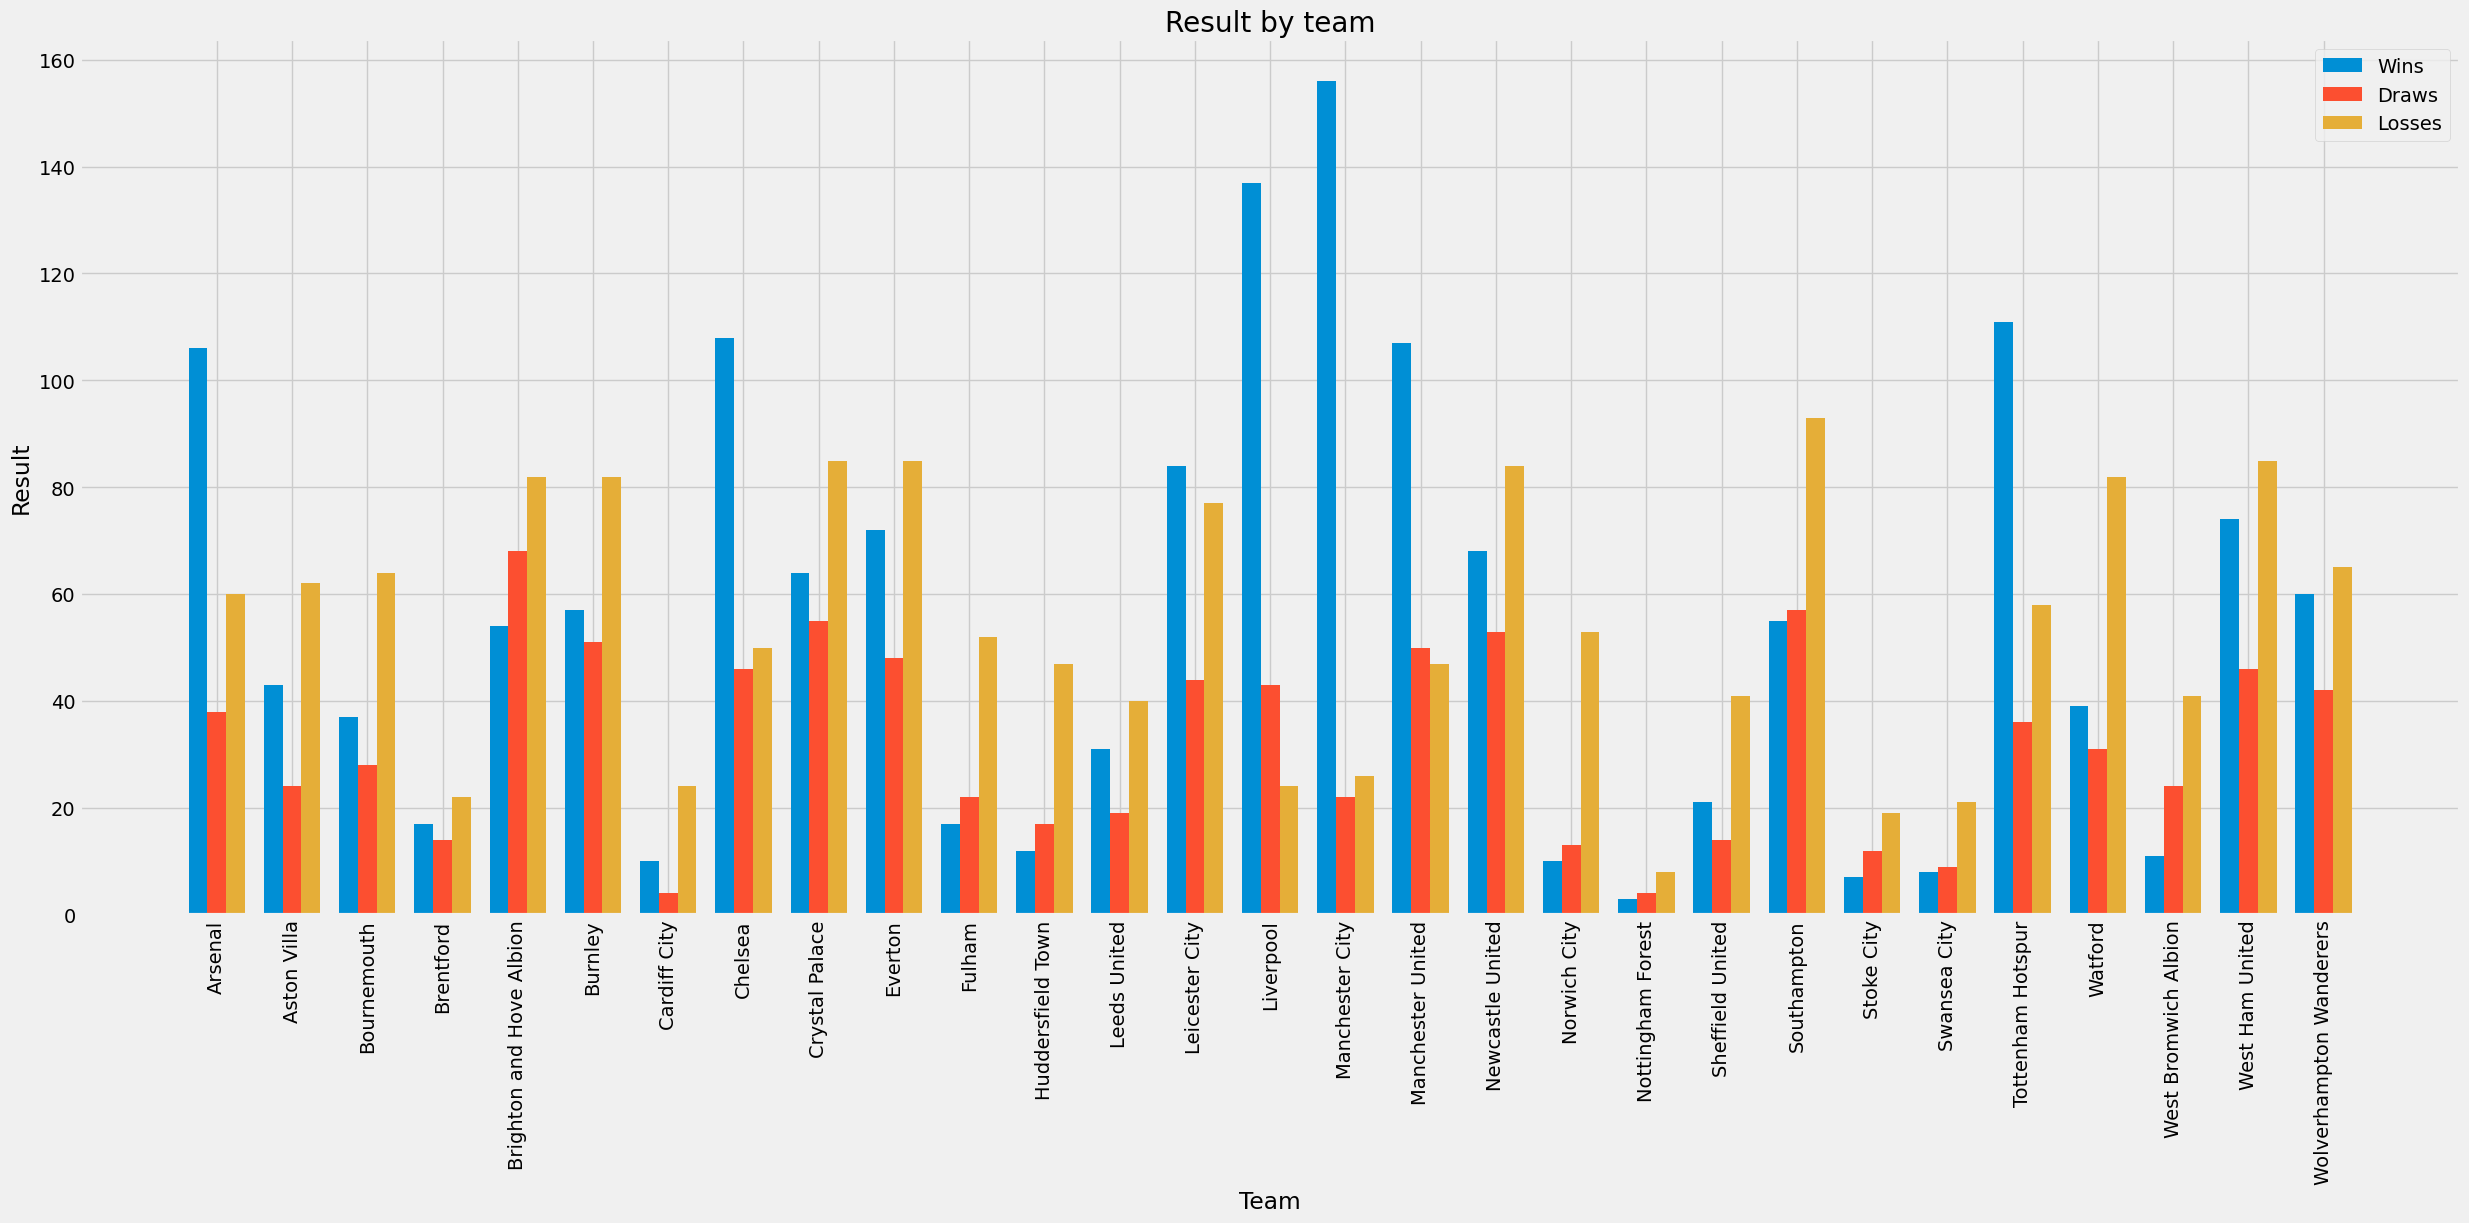

In [16]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

width = 0.25

wins = df[df['Result'] == 'W'].groupby('Team').size()
draws = df[df['Result'] == 'D'].groupby('Team').size()
losses = df[df['Result'] == 'L'].groupby('Team').size()

team_names = xg.index
ind = np.arange(len(team_names))

plt.bar(ind, wins, width, label = 'Wins')
plt.bar(ind + width, draws, width,  label = 'Draws')
plt.bar(ind + (width * 2), losses, width, label = 'Losses')

plt.title('Result by team')
plt.xlabel('Team')
plt.ylabel('Result')
plt.tight_layout()
ax.set_xticks(ind + width)
ax.set_xticklabels(team_names, rotation = 90)

plt.legend(loc = 'best')
plt.show()

Possession is also an interesting statistic in football and definitely plays into a teams tactics and play style. Some teams don't get and hold on to the ball very much and still manage to score and win. In other instances, some teams want to hold the ball as much as possible (sometimes 60-70% of the entire match) and in one lucky break, their opponents run up the field and score and the team with the landslide of posession loses. Because of these opposing tactics, I was looking at measuring whether or not teams that posess the ball more have better expected goals which is known to lead to more matches resulting in a win.

In the graph below, the average posession (the average percentage of time a team holds the ball) is graphed on the X axis and the average number of expected goals is graphed on the Y axis. What the data showed was interesting. There does seem to be a rough linear relationship between average xG and average posession. There are definite outliers in this graph with Manchester City, Liverpool, and Chelsea all holding the ball for >60% and having an average xG >1.6. These are very strong metrics.

An interesting team that stands out in this graph is Leeds United. In the prior graph, Leeds United lost about 25% more often than they won. However, in this graph it can be seen that Leeds United do a great job of posessing the ball more than all but 6/29 teams and have an xG greater than all but 7/29 teams. It seems like they lose more often than they should be based on the data. Very intersting result to uncover.

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_87880/2206984042.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (avg_poss[i], avg_xg[i]), xytext = (5,5), textcoords = 'offset points')


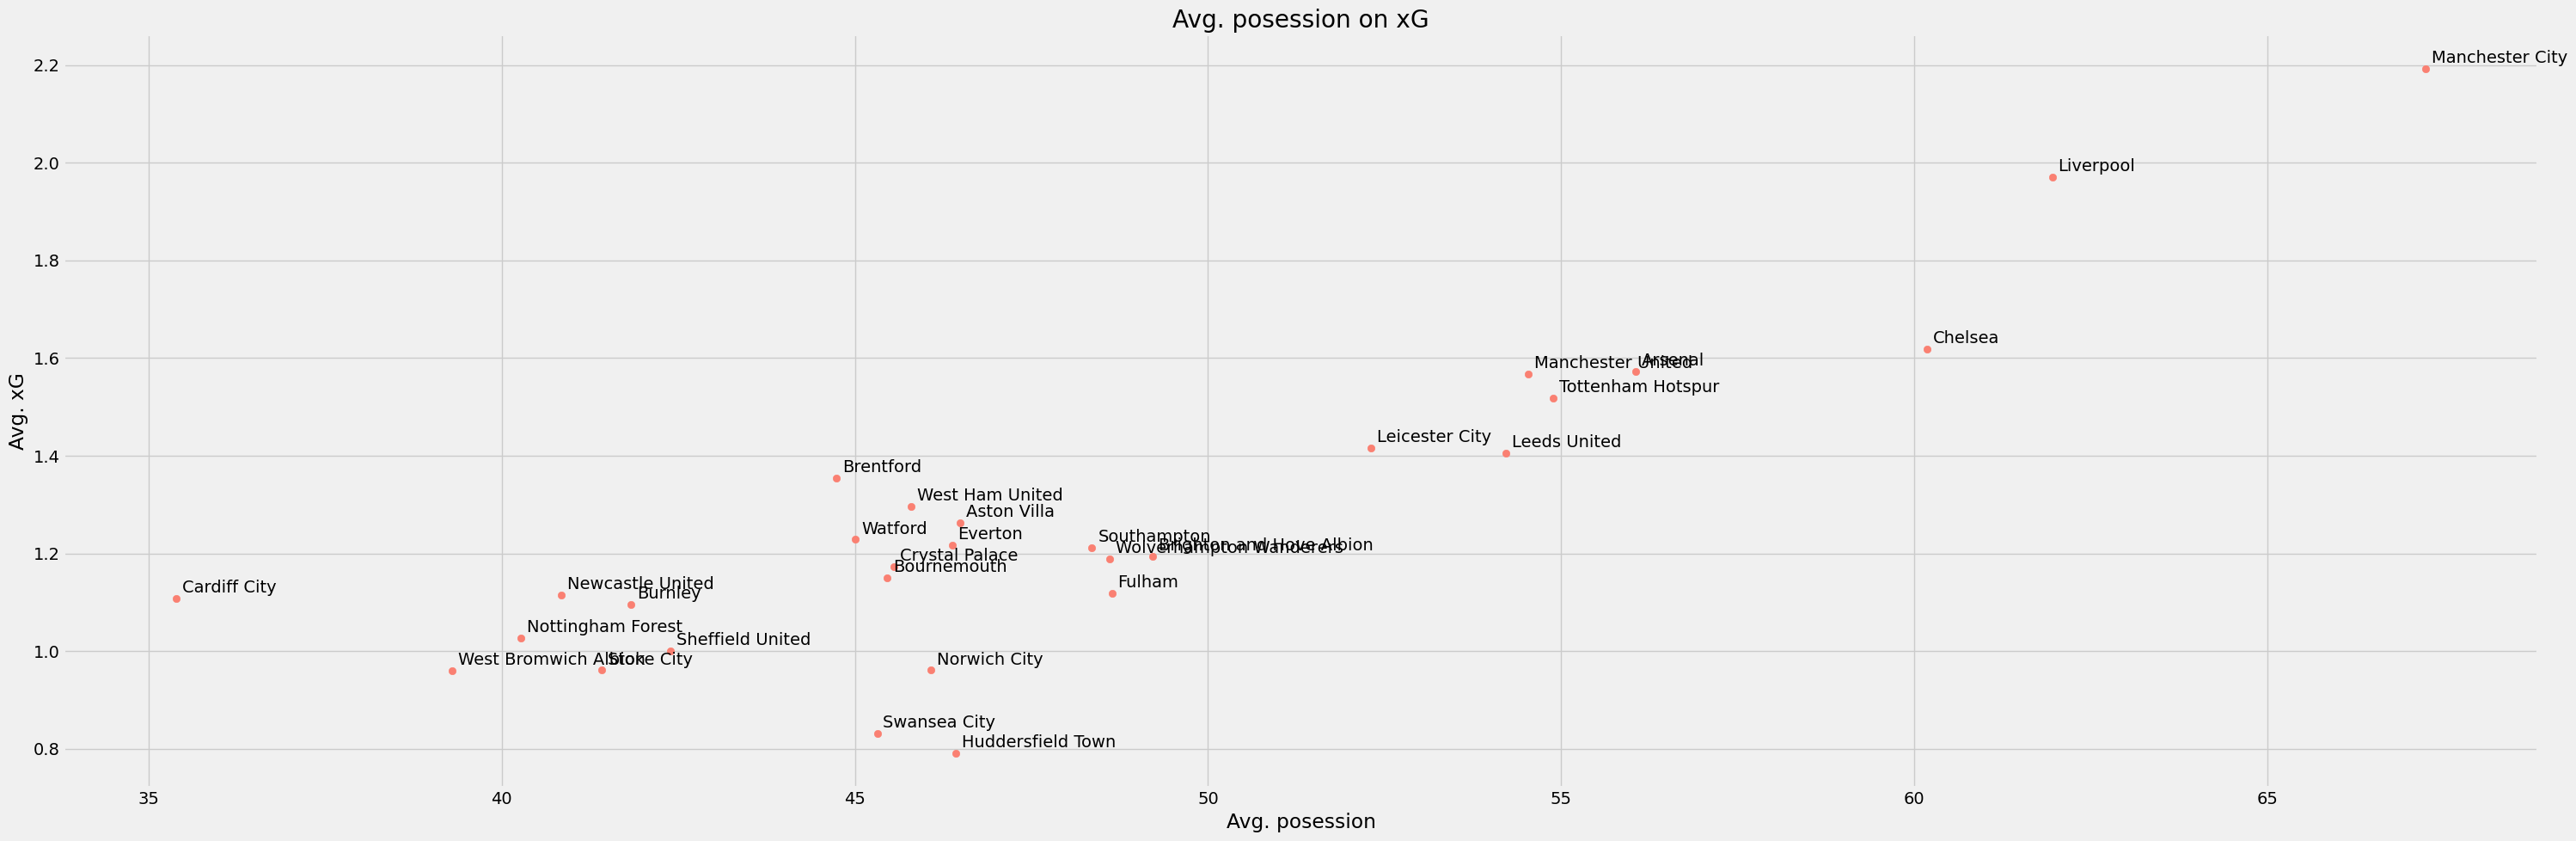

In [17]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (30, 10))

avg_poss  = df['Poss'].groupby(df['Team']).mean()
avg_xg = df['xG'].groupby(df['Team']).mean()
teams = np.sort(df['Team'].unique())

plt.title('Avg. posession on xG')
plt.xlabel('Avg. posession')
plt.ylabel('Avg. xG')
plt.tight_layout()

for i, txt in enumerate(teams):
    ax.annotate(txt, (avg_poss[i], avg_xg[i]), xytext = (5,5), textcoords = 'offset points')

plt.scatter(avg_poss, avg_xg, color = 'salmon')

plt.show()

I looked at average xG which we know has an impact on the outcome of a match, but did not look at xG at a more granular level. To do this, I created a xG boxplot graph that shows the mean xG, the inter quartile range (25% and 75% of the mean value, the 'minimum' and 'maximum' values that are defined as Q1 -/+ 1.5 * IQR) and any outliers that sit outside of this range.

There were some shockingly high and low values shown in the graph. Huddersfield Town's mean xG over the 2017-2022 season was about 0.6, yet managed to have a game where there xG was 3.4. This took place during the 2017-2018 season where they won 4-1 against Watford which is considered a massive result and must have been an exciting game for a Huddersfield Town's fan to watch. Speaking of Watford, Manchester City's highest xG in a game came against Watford in the 2019-2020 season where Manchester City had an xG of 5.9 and won 8-0. In this case, Manchester City well outperformed their xG and scored more chances than they were probabilistically supposed to. Impressive to say the least. 

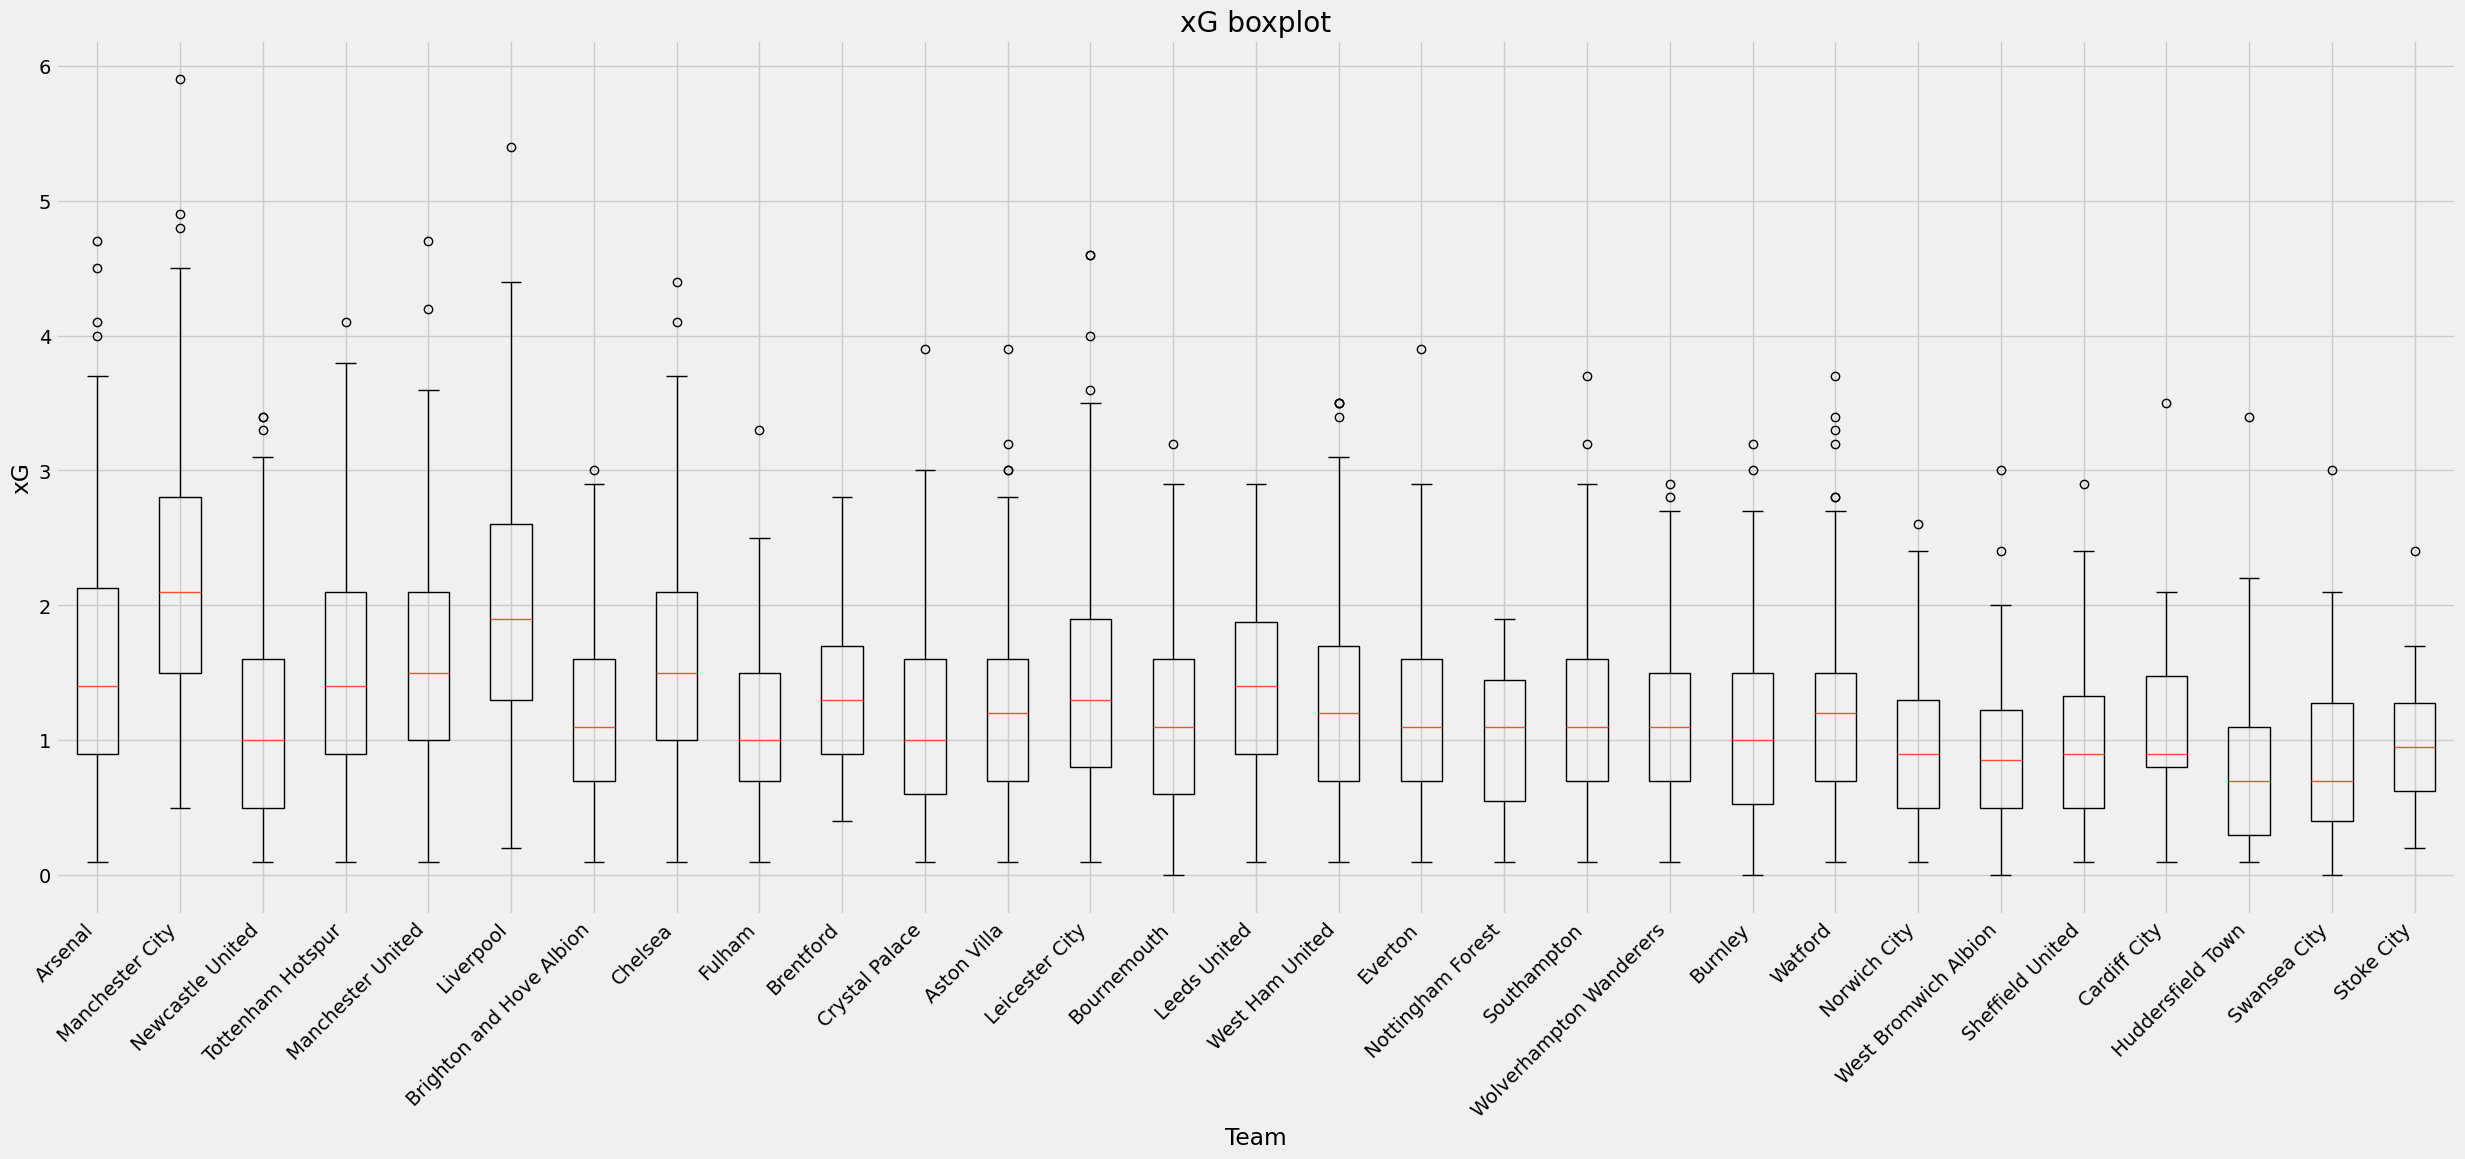

In [18]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

avg_xg = df.groupby('Team')['xG'].apply(list)

data_to_plot = [avg_xg[team] for team in df['Team'].unique()]


plt.boxplot(data_to_plot, labels = df['Team'].unique())

plt.title('xG boxplot')
plt.xlabel('Team')
plt.ylabel('xG')
plt.tight_layout()
plt.xticks(rotation=45, ha='right')

plt.show()

## Multiple logistic classification

Let's begin the modeling phase by starting with a multiple logistic regression model. However, before we can begin, it's a good time as ever to think through multicollinearity and how it could impact our multiple logistic classifier. Multicollinearity is where two or more independent predictors in a model are highly correlated with each other and can lead to inconsistent and harder to interpret results. There was potential multicollinearity in our scatterplot from above when average possession was graphed against average xG.

To determine if we have multicollinearity in our data, we can measure the Variance Inflation Factor (VIF) to determine if we need to drop additional columns to conduct feature engineering. VIF is calculated by taking a variable and regressing it against every other variable. The VIF score starts at 1 and has no upper limit. I will be on alert for values >10, which indicates multicollinearity exists with that variable.

To start, I will drop the ‘Date’ column as the VIF sklearn package does not accept any datetimes. I am also dropping Goals for (‘GF’) and Goals against (‘GA’) that have an obvious and direct relationship on the result of the match. I would like the model to work a bit harder to predict the outcome!

I also graphed a pairplot that can help with this exercise. On the diagonal, histograms are plotted. If the distribution of the histogram is symmetric and unimodal, this suggests normality within our data. This is good. Many asymmetrical peaks and troughs may represent multicollinearity within our data. The off diagonal scatter plots can also indicate collinearity if the plotted values follow a rough diagonal line. For example, the column ‘SoT’ seems to be both positively and negatively correlated with other features. This is an example of a column we might have to remove. 

In [19]:
# dropping both goals for and goals against as these two cols are in no doubt highly correlated with the result
dfc.drop(columns = ['GF', 'GA', 'Date'], inplace = True)

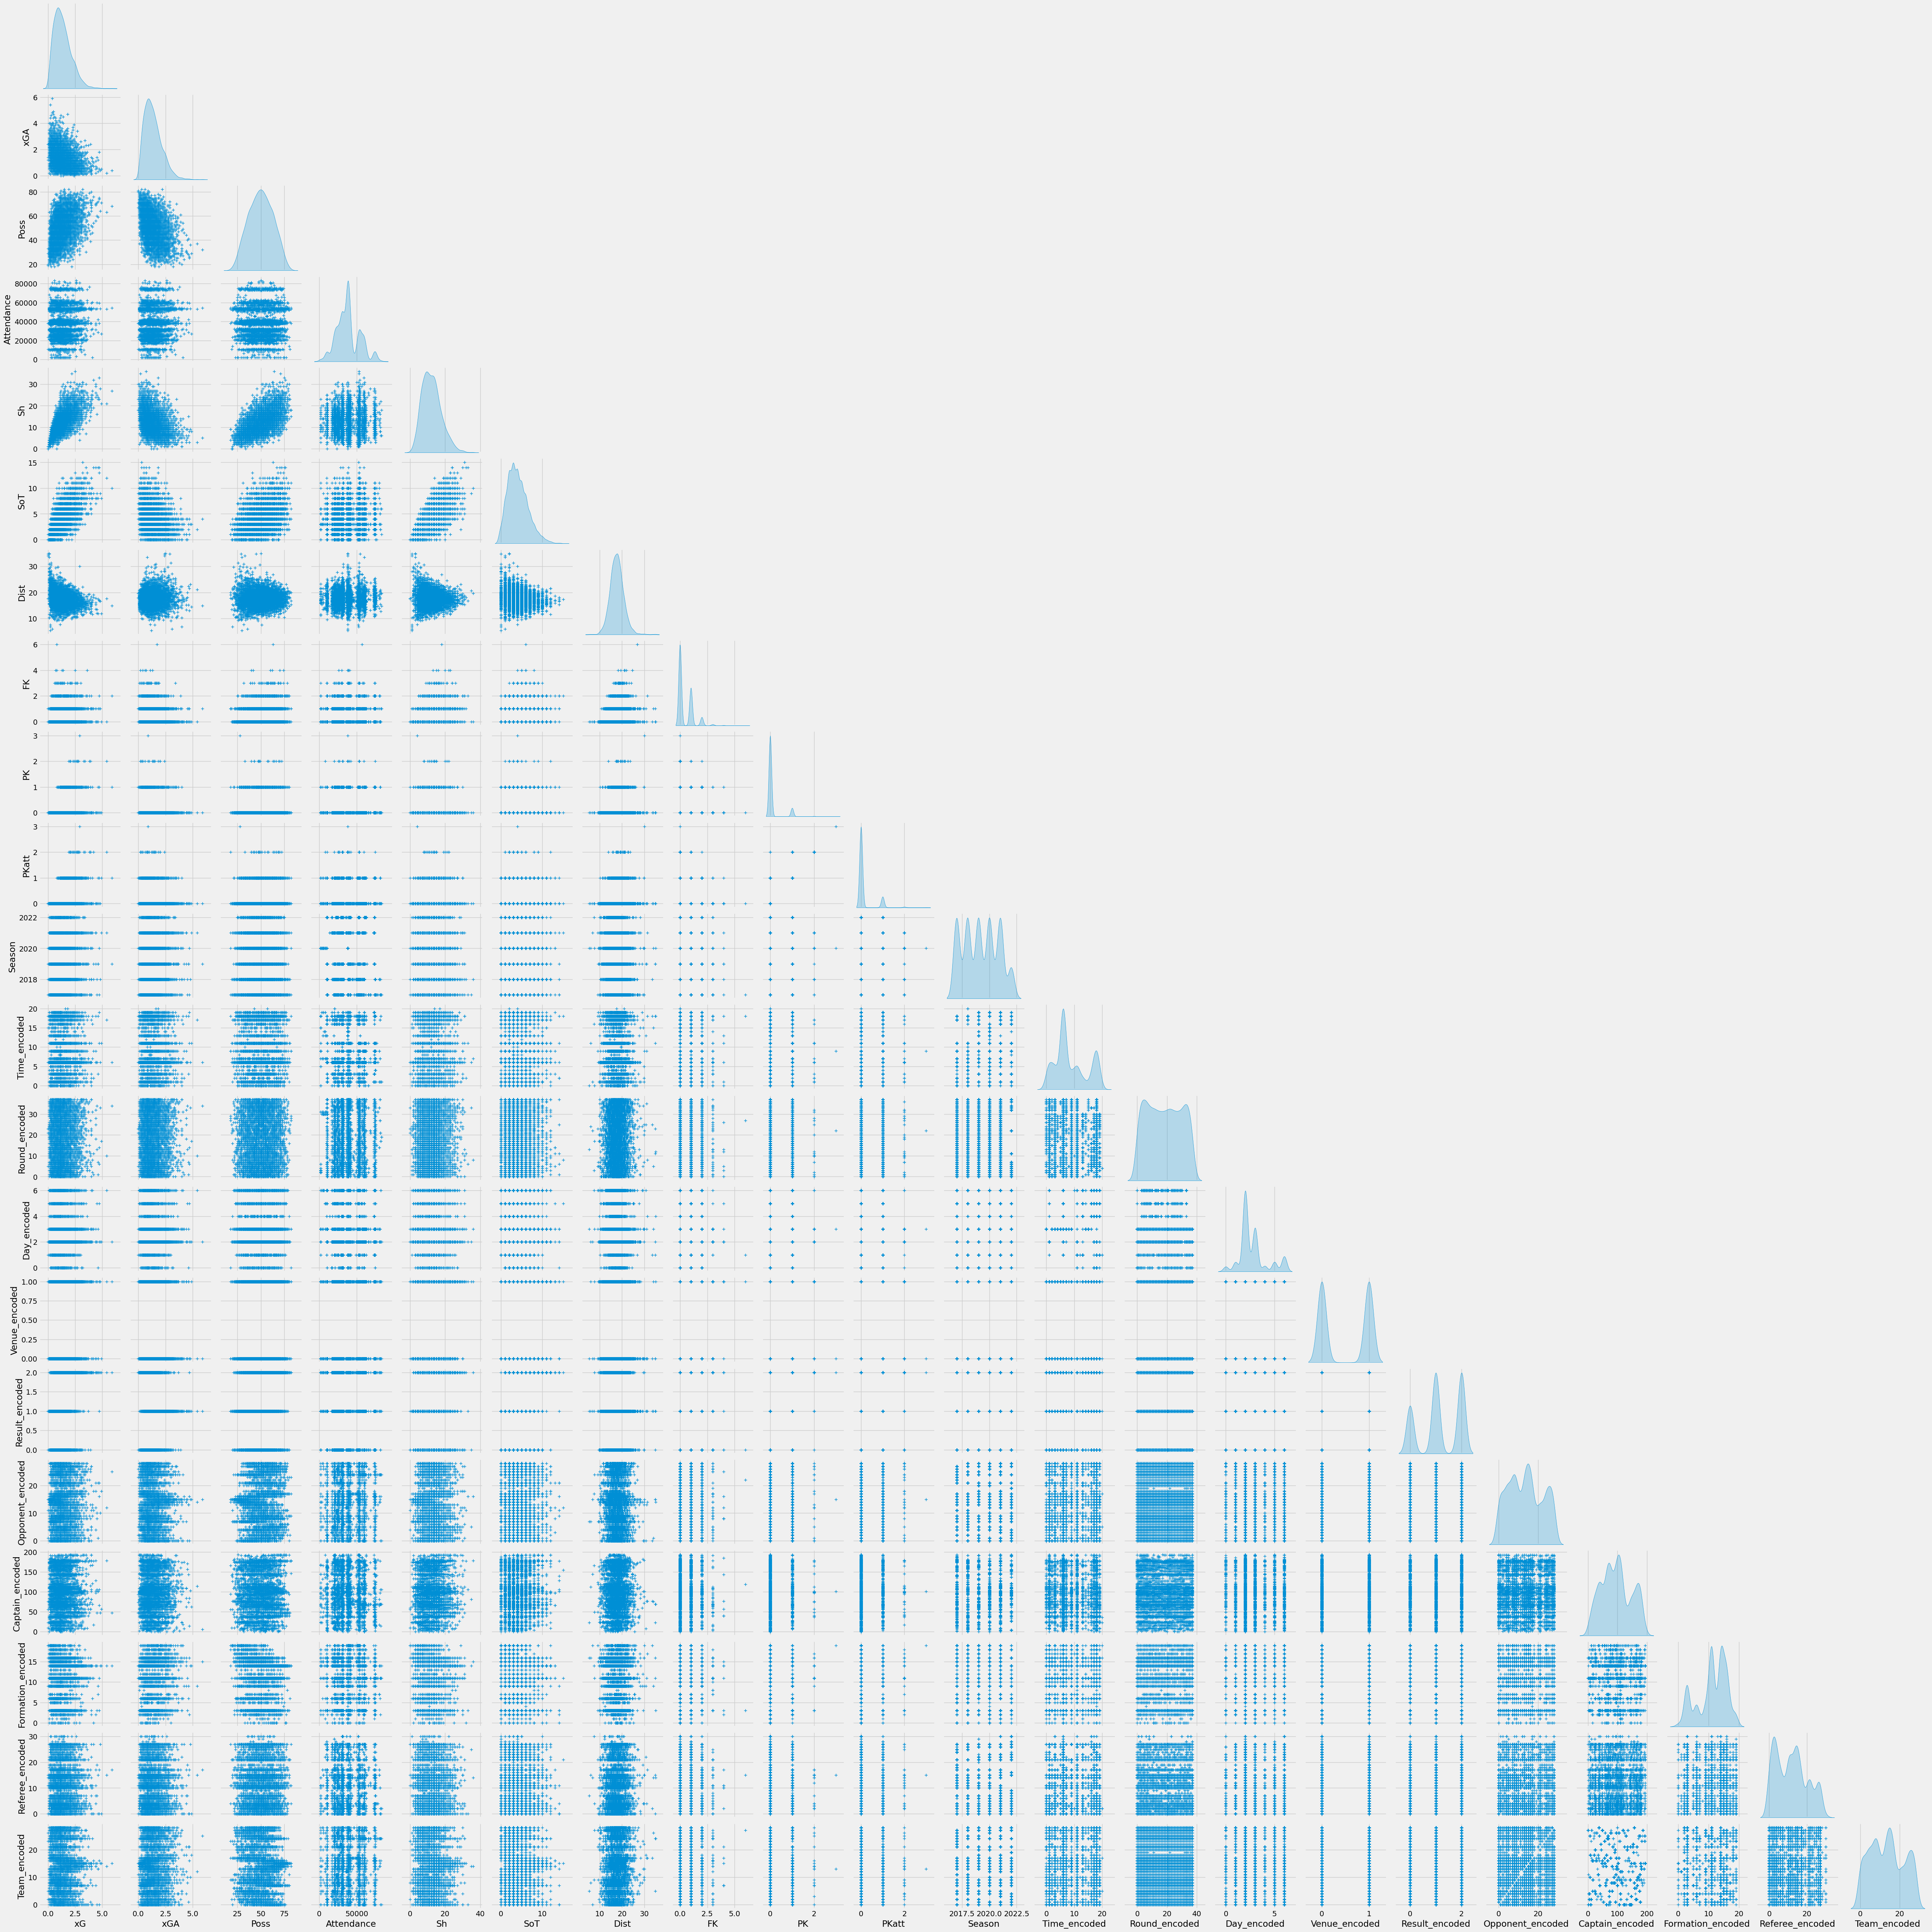

In [20]:
sns.pairplot(dfc, diag_kind = 'kde', corner = True, plot_kws = dict(marker = "+", linewidth = 1))

Now lets calculate the VIF of our dataset by using the variance_inflation_factor package from the sklean package. From looking at the results, there are many features that are greater than our 10 VIF threshold. It is clear that the ‘Season’ column and the ‘SoT’ target can be removed. In our data, we also include shots (‘Sh’) which would definitely relate to shots on target (‘SoT’) so I will remove this. I was surprised to see expected goals (‘xG’) also being highly correlated. I would have expected by losing goals for (‘GF’) that ‘xG’ would be ok but this was not the case. 

In terms of ‘Poss’ and ‘Dist’ I decided to attempt some feature engineering. Since we had an idea that these two columns were correlated, I decided to combine the two columns by dividing ‘Dist’ by ‘Poss’ to create a new col ‘Dist_div_poss’ to see if this column would be less collinear with the remaining columns.

In [21]:
vif = pd.DataFrame()
vif["variables"] = dfc.columns
vif["VIF"] = [variance_inflation_factor(dfc.values, i) for i in range(dfc.shape[1])]
print(vif)

            variables         VIF
0                  xG   14.460006
1                 xGA    4.930221
2                Poss   27.288014
3          Attendance    7.669084
4                  Sh   21.092779
5                 SoT    8.706388
6                Dist   49.206686
7                  FK    1.648838
8                  PK    5.204531
9               PKatt    5.895690
10             Season  115.848594
11       Time_encoded    3.743479
12      Round_encoded    3.690926
13        Day_encoded    5.324173
14      Venue_encoded    2.130356
15     Result_encoded    3.925153
16   Opponent_encoded    3.681172
17    Captain_encoded    4.905640
18  Formation_encoded    7.032714
19    Referee_encoded    3.071500
20       Team_encoded    3.811435


After dropping the columns and creating our new ‘Dist_div_poss’ column, let's re-run the VIF calculation and see what we end up with. The result is all of our VIF values are <10 which is exactly what we were after. These will be the final columns that will be used for our multiple logistic classification model.

In [22]:
dfc['Dist_div_poss'] = dfc['Dist'] / dfc['Poss']
dfc.drop(columns = ['Season', 'Sh', 'Dist', 'Poss', 'xG'], inplace = True)

# Calculating VIF
vif = pd.DataFrame()
vif["variables"] = dfc.columns
vif["VIF"] = [variance_inflation_factor(dfc.values, i) for i in range(dfc.shape[1])]
print(vif)

            variables       VIF
0                 xGA  4.498835
1          Attendance  7.012227
2                 SoT  4.625099
3                  FK  1.515752
4                  PK  5.195574
5               PKatt  5.312702
6        Time_encoded  3.662196
7       Round_encoded  3.448408
8         Day_encoded  4.985593
9       Venue_encoded  2.033354
10     Result_encoded  3.653064
11   Opponent_encoded  3.473654
12    Captain_encoded  4.425141
13  Formation_encoded  6.349821
14    Referee_encoded  2.921376
15       Team_encoded  3.528936
16      Dist_div_poss  9.698692


In [23]:
X = dfc
y = dfc['Result_encoded']

# I will train test split our dfc data frame withholding 20% of our data for testing purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [24]:
# building the logistic regression model and fitting on the training data
# it is important to include the multi_class input here so the model knows we have more than 2 outcomes
mlr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
mlr.fit(X_train, y_train)

/Users/cman/Desktop/code/predicting_premier_league_games/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

With our logistic regression model created and fit properly, let's use it to predict our testing data. To start I created a new dataframe ‘mlr_diff’ that we can use to visualize the five rows of our actual data vs. our predicted value. At first glance, there are quite a few mis-classifications. This is not a great sign, but let’s see how it scored overall.

In the next cell, I calculated the overall accuracy to be right around 50%. This is not very promising for using a logistic regression model to represent the data. I will look to improve upon this initial accuracy in my next model!

In [25]:
# predicting on our testing data
y_pred = mlr.predict(X_test)

In [26]:
# {'D': 0, 'L': 1, 'W': 2}
mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
mlr_diff.head()

Actual value  Predicted value
599              2                1
752              2                2
2019             1                1
1001             0                1
3568             1                1

In [27]:
score = round(metrics.accuracy_score(y_test, y_pred), 4)
print(f'The accuracy of the model is: {score}')

The accuracy of the model is: 0.4969


## Decision tree classifier

The next model I will be attempting to build is a Decision Tree classifier. The decision tree is a supervised algorithm that data points are split according to parameters (called root nodes). When building the tree, it follows a top down approach where the root node of the tree is at the top and the outcomes are represented by tree leaves. I will present the visual representation of the decision tree later on in this notebook.

Creating the decision tree is simple. I create a DecisionTreeClassifier instance and fit it on the training data as before. Then I call the predict function on the testing data. Now similarly I can create a dataframe that will visualize the first five actual values and our models predictions.

From looking at the first five rows, the model is 5/5 correct! This model seems to be much more effective, but how well did the rest of the predictions go?

In [28]:
clf = DecisionTreeClassifier(random_state = 42)

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [29]:
clf_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
clf_diff.head()

Actual value  Predicted value
599              2                2
752              2                2
2019             1                1
1001             0                0
3568             1                1

Looking at the overall accuracy, I’m very surprised. The model was 100% perfect in it’s predictions. That is very impressive to me as we only received a 50% prediction with our logistic regression model. Since parameter tuning is not necessary for a model that is already predicted perfectly, I will not configure anything else.

The final bit of code in this section visualizes the decision tree. The first line in the root node (Result_encoded <= 1.5) represents the first split that was completed where the encoded result target column was <= 1.5 meaning the wins were split to the right. We can tell from the ‘samples’ line that of the 3273 rows, 2039 samples were split into the left tree and 1234 samples were split to the right tree. In the second split the criterion was where the result_encoded value was <= 0.5. The values that were less than 0.5 were losses and were split left, where the remaining 1290 were labeled as draws. It is clear that this decision handled and split the data very well.

In [30]:
# non optimized accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


[Text(0.6, 0.8333333333333334, 'Result_encoded <= 1.5\ngini = 0.65\nsamples = 3273\nvalue = [749, 1290, 1234]\nclass = D'),
 Text(0.4, 0.5, 'Result_encoded <= 0.5\ngini = 0.465\nsamples = 2039\nvalue = [749, 1290, 0]\nclass = D'),
 Text(0.2, 0.16666666666666666, 'gini = 0.0\nsamples = 749\nvalue = [749, 0, 0]\nclass = L'),
 Text(0.6, 0.16666666666666666, 'gini = 0.0\nsamples = 1290\nvalue = [0, 1290, 0]\nclass = D'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 1234\nvalue = [0, 0, 1234]\nclass = W')]

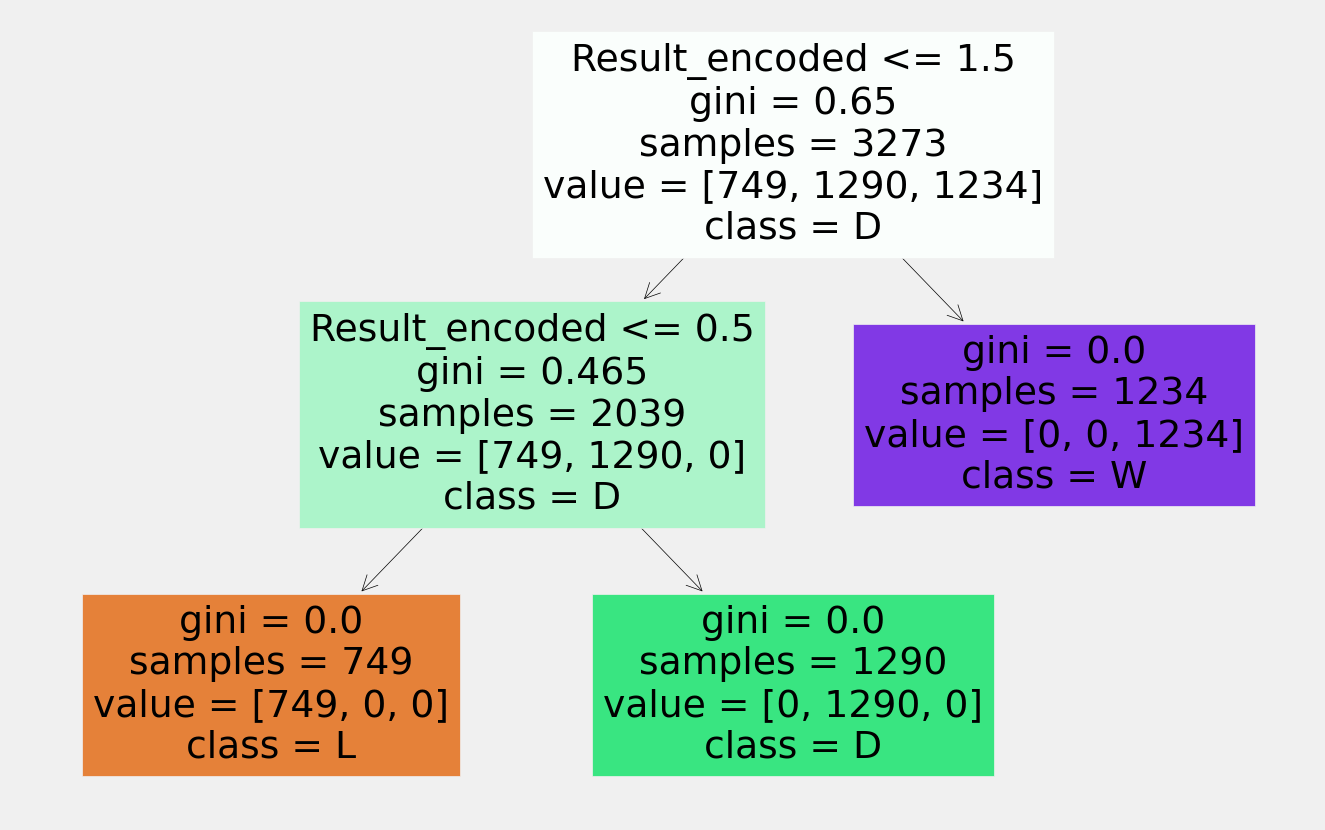

In [31]:
fig = plt.figure(figsize=(15,10))

tree.plot_tree(clf,
               filled = True,
               feature_names = X_train.columns, class_names = ['L', 'D', 'W'])

## Adaboost classification

The third and final model I will attempt to create will be the AdaBoost classification model. Since the decision tree classifier achieved 100% accuracy, I can attempt to create an AdaBoost model that can match it. To begin, let's define an AdaBoostClassifier instance and fit it to our training data as before. Then we can predict the model on our testing data.

Now looking into the full accuracy, we’ve done it again. 100% accuracy with our baseline AdBoost model. Can’t beat that. However, for practice's sake, I wanted to see what would happen to the overall accuracy if I changed the Adaboost parameters by using a grid search. To do this, I used the GridSearchCV method and added a few values to test for the ‘n_estimators’ and ‘learning_rate’ parameters. For each permutation of n_estimators and learning_rate values, I printed both the mean test score and the standard deviation.

Viewing the results, it is surprising to me the number of different parameters that lead to a 100% accuracy. Many of the n_estimator values with a low learning rate gets us to 100%. However, you will notice at the bottom of the results, a very high (in this case 70) learning_rate leads to a decrease in accuracy to about 77%. It is interesting to see that the learning_rate has a high impact on the overall accuracy. 

In [32]:
abc = AdaBoostClassifier(random_state = 42)

abc_fit = abc.fit(X_train, y_train)

y_pred_abc = abc_fit.predict(X_test)

/Users/cman/Desktop/code/predicting_premier_league_games/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [33]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_abc))

Accuracy: 1.0


In [34]:
abc_opt = AdaBoostClassifier(random_state = 42, algorithm = 'SAMME')

grid = dict()
grid['n_estimators'] = [1,2,3,4,5,6,7,8,9,10]
grid['learning_rate'] = [5,20,70]

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

grid_search = GridSearchCV(estimator = abc_opt, param_grid = grid, cv = cv, scoring = 'accuracy')

grid_result = grid_search.fit(X_train, y_train)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f'{mean} {stdev} with: {param}')

/Users/cman/Desktop/code/predicting_premier_league_games/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:695: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/Users/cman/Desktop/code/predicting_premier_league_games/.venv/lib/python3.12/site-packages/sklearn/base.py:1474: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimator, *args, **kwargs)
/Users/cman/Desktop/code/predicting_premier_league_games/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:695: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/Users/cman/Desktop/code/predicting_premier_league_games/.venv/lib/python3.12/site-packages/sklearn/base.py:1474: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimato

Best: 0.7711577907063477 using {'learning_rate': 5, 'n_estimators': 1}
0.7711577907063477 0.0009033593610532841 with: {'learning_rate': 5, 'n_estimators': 1}
0.6229768031625269 0.0011190981973123993 with: {'learning_rate': 5, 'n_estimators': 2}
0.7711577907063477 0.0009033593610532841 with: {'learning_rate': 5, 'n_estimators': 3}
0.6229768031625269 0.0011190981973123993 with: {'learning_rate': 5, 'n_estimators': 4}
0.7711577907063477 0.0009033593610532841 with: {'learning_rate': 5, 'n_estimators': 5}
0.6229768031625269 0.0011190981973123993 with: {'learning_rate': 5, 'n_estimators': 6}
0.7711577907063477 0.0009033593610532841 with: {'learning_rate': 5, 'n_estimators': 7}
0.6229768031625269 0.0011190981973123993 with: {'learning_rate': 5, 'n_estimators': 8}
0.7711577907063477 0.0009033593610532841 with: {'learning_rate': 5, 'n_estimators': 9}
0.6229768031625269 0.0011190981973123993 with: {'learning_rate': 5, 'n_estimators': 10}
0.7711577907063477 0.0009033593610532841 with: {'learning_

/Users/cman/Desktop/code/predicting_premier_league_games/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:695: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/Users/cman/Desktop/code/predicting_premier_league_games/.venv/lib/python3.12/site-packages/sklearn/base.py:1474: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimator, *args, **kwargs)
/Users/cman/Desktop/code/predicting_premier_league_games/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:695: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/Users/cman/Desktop/code/predicting_premier_league_games/.venv/lib/python3.12/site-packages/sklearn/base.py:1474: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimato

## Conclusion

In conclusion, throughout this project I was able to apply the supervised learning models I had learned about throughout the class to a dataset of my choice. I learned a tremendous amount and refined my skills in data cleaning, EDA and implementing a logistic regression. I had no previous experience calculating the VIF measure of multicollinearity or with creating an AdaBoost classifier (outside of DTSA-5509 assignments). It was a great exercise to complete.

Looking back on my approach, one reason why I think my logistic regression model achieved such a low accuracy compared to the decision tree classifier and the AdaBoost model was that the data did not have a linear relationship to begin with. There seemed to be a more complex relationship between the features that the decision tree classifier and the AdaBoost model was able to pick up on.

One way I could have improved the overall project was to include additional data. Football (soccer) like most other sports is heavily reliant on statistics of all types. Although it was good to have baseline match statistics, I believe that additional passing and more detailed possession statistics could have had an impact on the models and may have yielded different results.

## Citations

1. Kaggle Dataset: Kydyraliev, I. (2022, December 23). 2017_2022 EPL fixtures, shots, assists, passing,.. Kaggle. https://www.kaggle.com/datasets/iliaskydyraliev/2017-2022-epl-fixtures-shots-assists-passing/data
2. fbref: Premier League stats. FBref.com. (n.d.). https://fbref.com/en/comps/9/Premier-League-Stats
3. Bhandari, A. (2024, February 15). Multicollinearity: Causes, effects and detection using VIF (updated 2024). Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/ 